# Evaluation

References for text similarity metrics: \
[BLEU Score](https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b) -
[ROUGE Score](https://medium.com/@eren9677/text-summarization-387836c9e178) -
[NIST Score](https://aclanthology.org/www.mt-archive.info/HLT-2002-Doddington.pdf) -
[METEOR Score](https://aclanthology.org/W05-0909.pdf) -
[BERT Score](https://arxiv.org/pdf/1904.09675) -
[BLEURT Score](https://aclanthology.org/2020.acl-main.704.pdf)

In [ ]:
# Installazione di BLEURT
#import os
#!git clone https://github.com/google-research/bleurt.git
#os.chdir('bleurt')
#!pip install .

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from rouge_score import rouge_scorer
import bert_score
from bleurt import score as bleurt_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import warnings
from pydantic import BaseModel, Field
from typing import Optional, TypedDict, Literal
from transformers import logging

#### Settings

In [2]:
warnings.filterwarnings("ignore")
logging.set_verbosity_error()

In [3]:
data_folder = './data/'
result_folder = './results/'

In [7]:
debug_mode = False # set to True to test evaluation of stage 3

#### LLM

In [8]:
model_name = 'mistral'

In [9]:
#model_name = 'deepseek'

#### Classes to reload answers from Tree of Thought Graph

In [ ]:
class HateClassification(BaseModel):
    hate_class: Literal['implicit_hate','not_hate']
    interpretations : Optional[str]
    explanation : Optional[str]
    confidence : Optional[float]
    recursion_level : int = 0

class ImplicitHateClassification(BaseModel):
    implicit_class_1: Literal['white_grievance', 'irony', 'stereotypical', 'incitement', 'other', 'threatening', 'inferiority', 'other']
    confidence_class_1: float
    explanation : str

class ImpliedMeaning(BaseModel):
    targeted_group: str
    implied_statement: str

# Evaluation Stage 1

In [10]:
test_file_stg1 = data_folder + "implicit_hate_test_stg1.csv"

In [11]:
def evaluate_stage_1(strategy, gold_file, pred_file):
    
    df_gold = pd.read_csv(gold_file, encoding = 'utf-8')
    df_pred = pd.read_csv(pred_file, encoding = 'utf-8')

    label_selector = ['implicit_hate', 'not_hate' ]
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    labels_gold = df_gold['class']
    predictions = df_pred['class']

    f1_macro = f1_score(labels_gold, predictions, average = "macro")
    accuracy = accuracy_score(labels_gold, predictions)
    precision = precision_score(labels_gold, predictions, average = "macro")
    recall = recall_score(labels_gold, predictions, average = "macro")
    
    clf_report = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector, digits=4)
    clf_report_dict = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector,
                                            digits=4, output_dict=True)
    clf_report_df = pd.DataFrame(clf_report_dict)
    
    values_export = clf_report_df.loc["f1-score", label_selector].T.values
    values_export = "\t".join([str(round(v,4)) for v in values_export])
    
    report = f"""F1-macro: {str(round(f1_macro, 4))} accuracy: {str(round(accuracy, 4))} precision: {str(round(precision, 4))} recall: {str(round(recall, 4))} \n\n{clf_report}"""

    print(strategy + ": " + report)    

    confusion_matrix = metrics.confusion_matrix(labels_gold, predictions,labels = label_selector)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_selector)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.show()

    return pd.DataFrame([{'Strategy' : strategy, "F1-macro" : f1_macro, 'Precision' : precision, 'Recall' : recall, 'Accuracy' : accuracy}])

    

### Baseline

Baseline: F1-macro: 0.6004 accuracy: 0.6017 precision: 0.7014 recall: 0.6829 

               precision    recall  f1-score   support

implicit_hate     0.4641    0.9488    0.6233      1036
     not_hate     0.9387    0.4171    0.5775      1947

     accuracy                         0.6017      2983
    macro avg     0.7014    0.6829    0.6004      2983
 weighted avg     0.7739    0.6017    0.5934      2983



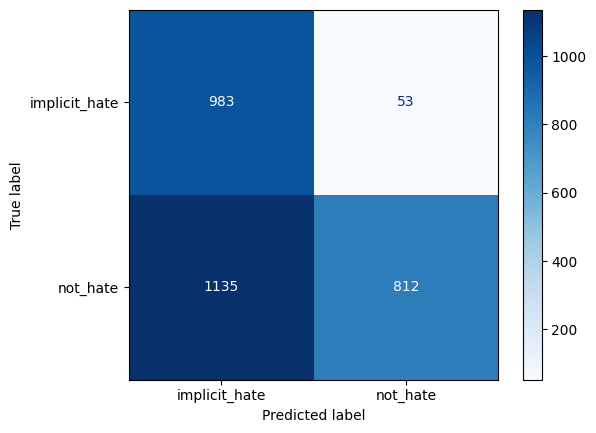

In [12]:
result_file_stg1 = result_folder + model_name + "_result_baseline_stg1.csv"
df_baseline_stg1 = evaluate_stage_1(
    'Baseline', 
    test_file_stg1, 
    result_file_stg1
)

### Prompt Tree of Thoughts

ToT Prompt: F1-macro: 0.6414 accuracy: 0.6414 precision: 0.7103 recall: 0.7091 

               precision    recall  f1-score   support

implicit_hate     0.4911    0.9304    0.6428      1034
     not_hate     0.9295    0.4879    0.6399      1947

     accuracy                         0.6414      2981
    macro avg     0.7103    0.7091    0.6414      2981
 weighted avg     0.7775    0.6414    0.6409      2981



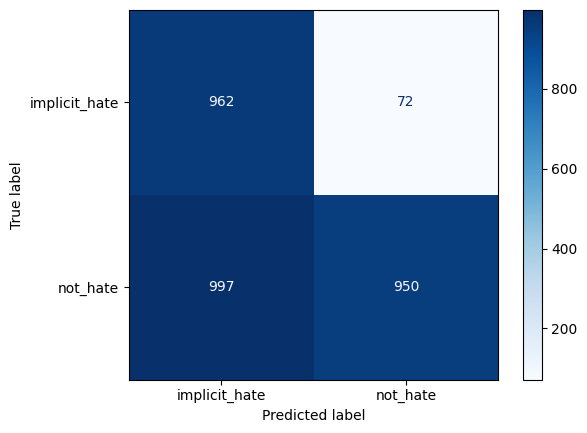

In [13]:
result_file_stg1 = result_folder + model_name + "_result_prompt_tot_stg1.csv"
df_prompt_tot_stg1 = evaluate_stage_1(
    "ToT Prompt",
    test_file_stg1, 
    result_file_stg1 
)

### Graph Tree of Thoughts

ToT Graph: F1-macro: 0.6755 accuracy: 0.6762 precision: 0.7188 recall: 0.7304 

               precision    recall  f1-score   support

implicit_hate     0.5192    0.9076    0.6605      1028
     not_hate     0.9185    0.5533    0.6905      1934

     accuracy                         0.6762      2962
    macro avg     0.7188    0.7304    0.6755      2962
 weighted avg     0.7799    0.6762    0.6801      2962



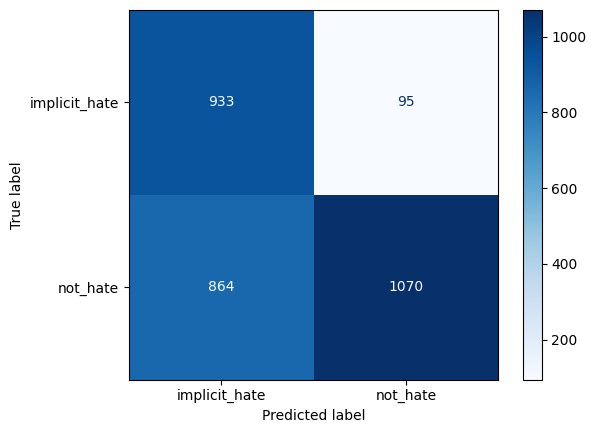

In [14]:
result_file_stg1 = result_folder + model_name + "_result_graph_stg1.csv"
df_graph_stg1 = evaluate_stage_1(
    "ToT Graph", 
    test_file_stg1, 
    result_file_stg1
)

### Optimizer MIPRO

Optimization: F1-macro: 0.7293 accuracy: 0.7357 precision: 0.7353 recall: 0.7591 

               precision    recall  f1-score   support

implicit_hate     0.5842    0.8364    0.6879      1045
     not_hate     0.8863    0.6818    0.7707      1955

     accuracy                         0.7357      3000
    macro avg     0.7353    0.7591    0.7293      3000
 weighted avg     0.7811    0.7357    0.7419      3000



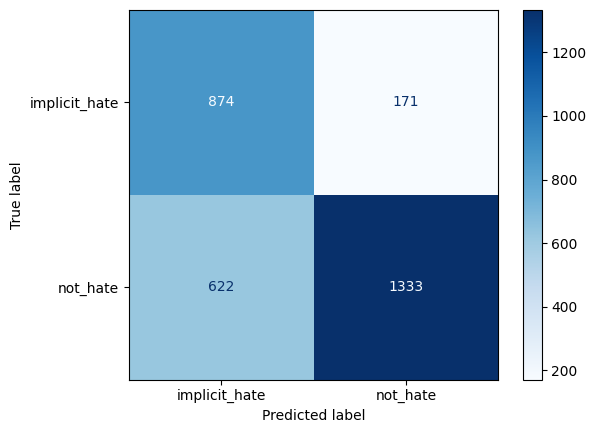

In [200]:
result_file_stg1 = result_folder + model_name + "_result_optimizer_stg1.csv"
df_optim_stg1 = evaluate_stage_1(
    "Optimization", 
    test_file_stg1, 
    result_file_stg1
)

## Results Stage 1

In [201]:
df_result_stg1 = pd.concat([df_baseline_stg1, df_prompt_tot_stg1, df_graph_stg1, df_optim_stg1])

In [202]:
df_result_stg1.to_excel(result_folder + model_name + '_evaluation_stg1.xlsx', index = False)

In [203]:
df_result_stg1 = pd.read_excel(result_folder + model_name + '_evaluation_stg1.xlsx')

In [204]:
df_result_stg1.round(4).head()

,Strategy,F1-macro,Precision,Recall,Accuracy
0,Baseline,0.6004,0.7014,0.6829,0.6017
1,ToT Prompt,0.6414,0.7103,0.7091,0.6414
2,ToT Graph,0.6755,0.7188,0.7304,0.6762
3,Optimization,0.7293,0.7353,0.7591,0.7357


### Qualitative analysis (MIPRO results)

In [23]:
df_gold_stg1 = pd.read_csv(data_folder + "implicit_hate_test_stg1.csv", encoding = 'utf-8')
df_pred_stg1 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg1.csv", encoding = 'utf-8')

#### Confidence

In [24]:
print(df_pred_stg1['confidence'].mean())

0.8368633333333334


In [25]:
df_pred_stg1.rename(columns={'class': 'class_pred'}, inplace=True)

In [26]:
df_pred_stg1.head()

,post_id,class_pred,confidence,explanation
0,8044,not_hate,0.90,The post is a neutral request for someone to w...
1,1709,not_hate,0.80,The post discusses political dynamics and does...
2,8898,not_hate,0.90,"The post is a general comment about ""fake news..."
3,6860,not_hate,0.90,The post is a factual statement about a legal ...
4,15379,implicit_hate,0.75,The post suggests that Hindus are suffering wh...


In [27]:
df_merge_stg1 = pd.merge(df_gold_stg1, df_pred_stg1, on = 'post_id')

In [28]:
df_merge_stg1.head()

,post_id,post,class,class_pred,confidence,explanation
0,8044,pl . watch odessa file on youtube and say sorr...,not_hate,not_hate,0.90,The post is a neutral request for someone to w...
1,1709,the left is losing their exalted status as def...,not_hate,not_hate,0.80,The post discusses political dynamics and does...
2,8898,more fake news,not_hate,not_hate,0.90,"The post is a general comment about ""fake news..."
3,6860,dr . goebbels ' estate sues publisher for prin...,not_hate,not_hate,0.90,The post is a factual statement about a legal ...
4,15379,poor hindus are suffering ; not kcr or owasis,not_hate,implicit_hate,0.75,The post suggests that Hindus are suffering wh...


#### Confidence of correct predictions

In [29]:
print(df_merge_stg1[df_merge_stg1['class'] == df_merge_stg1['class_pred']]['confidence'].mean())

0.8530539193475306


#### Confidence of wrong predictions

In [30]:
print(df_merge_stg1[df_merge_stg1['class'] != df_merge_stg1['class_pred']]['confidence'].mean())

0.7918032786885247


#### Examples of misclassified not hate posts with explanation

In [31]:
df_fp = df_merge_stg1[(df_merge_stg1['class'] == 'not_hate') & (df_merge_stg1['class_pred'] == 'implicit_hate')]

In [32]:
for idx, row in df_fp.sample(10).iterrows():
    print('\nPost: ' + row['post'])
    print('Confidence: ' + str(row['confidence']))
    print('Explanation: ' + row['explanation'])


Post: idea of holding events on private property ( so antifa would be aggressors  trespassing ) is great way of
Confidence: 0.75
Explanation: The post suggests a strategy to make "antifa" appear as aggressors by holding events on private property, thereby framing them as trespassers. This implies a negative and potentially hateful attitude towards the "antifa" group, although it is not explicitly stated. The confidence level is moderately high due to the indirect but clear implication of animosity.

Post: more federal money for real americans !
Confidence: 0.75
Explanation: The phrase "real Americans" implies an exclusionary view, suggesting that certain groups may not be considered "real" Americans. This can be interpreted as implicit hate speech, as it indirectly targets and excludes specific groups based on their perceived lack of belonging.

Post: but to say it is 1000  000 times better to kill a jew than a palestinian is false . they are equal
Confidence: 0.9
Explanation: The pos

#### Was deepening used?

In [34]:
df_resp = pd.DataFrame(columns = ['post', 'explanation', 'recursion_level'])
files = glob.glob(result_folder + '/responses/*.json')

for filename in files:
    try: 
        with open(filename, 'r') as f:
            text = f.read()
            obj = json.loads(text)
            hate = eval(obj['hate_class']['repr'])
            new_row = {
                'post': obj['post'], 
                'explanation' : hate.explanation, 
                'recursion_level' : hate.recursion_level
            }
            df_resp = pd.concat([df_resp, pd.DataFrame([new_row])])
    except:
        print(filename)


#### Deepening was never used :(

In [35]:
df_resp[df_resp['recursion_level'] > 1]

,post,explanation,recursion_level


# Evaluation Stage 2

In [36]:
test_file_stg2 = data_folder + "implicit_hate_test_stg2.csv"

In [37]:
def evaluate_stage_2(strategy, gold_file, pred_file):

    df_gold = pd.read_csv(gold_file, encoding = "utf-8")
    df_pred = pd.read_csv(pred_file, encoding = "utf-8")
    
    label_selector = ['incitement', 'white_grievance', 'inferiority', 'stereotypical', 'irony', 'threatening', 'other']
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
        
    labels_gold = df_gold['implicit_class']
    predictions = df_pred['implicit_class']
    
    f1_macro = f1_score(labels_gold, predictions, average = "macro")
    accuracy = accuracy_score(labels_gold, predictions)
    precision = precision_score(labels_gold, predictions, average = "macro")
    recall = recall_score(labels_gold, predictions, average = "macro")
    
    clf_report = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector, digits=4)
    clf_report_dict = classification_report(labels_gold, predictions, labels = label_selector, target_names = label_selector,
                                            digits=4, output_dict=True)
    clf_report_df = pd.DataFrame(clf_report_dict)
    
    values_export = clf_report_df.loc["f1-score", label_selector].T.values
    values_export = "\t".join([str(round(v,4)) for v in values_export])
    
    report = f"""F1-macro: {str(round(f1_macro, 4))} accuracy: {str(round(accuracy, 4))} precision: {str(round(precision, 4))} recall: {str(round(recall, 4))} \n\n{clf_report}
    """
    print(strategy + ": " + report)
    print(values_export)
    print("\n\n")
    
    # Compute the confusion matrix
    cm = metrics.confusion_matrix(labels_gold, predictions, labels = label_selector)
    
    # Plot the confusion matrix with percentages
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks and label them with the respective list entries
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=label_selector, yticklabels=label_selector,
           title='Implicit hate classification',
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "#274c81")
    #fig.tight_layout()
    plt.show()

    return pd.DataFrame([{'Strategy' : strategy, "F1-macro" : f1_macro, 'Precision' : precision, 'Recall' : recall, 'Accuracy' : accuracy}])


### Baseline

Baseline: F1-macro: 0.4699 accuracy: 0.5522 precision: 0.4934 recall: 0.4679 

                 precision    recall  f1-score   support

     incitement     0.5082    0.3464    0.4120       179
white_grievance     0.5962    0.7054    0.6462       224
    inferiority     0.5135    0.6230    0.5630       122
  stereotypical     0.4798    0.6257    0.5431       171
          irony     0.6100    0.5259    0.5648       116
    threatening     0.7458    0.4490    0.5605        98
          other     0.0000    0.0000    0.0000        10

       accuracy                         0.5522       920
      macro avg     0.4934    0.4679    0.4699       920
   weighted avg     0.5577    0.5522    0.5440       920

    
0.412	0.6462	0.563	0.5431	0.5648	0.5605	0.0





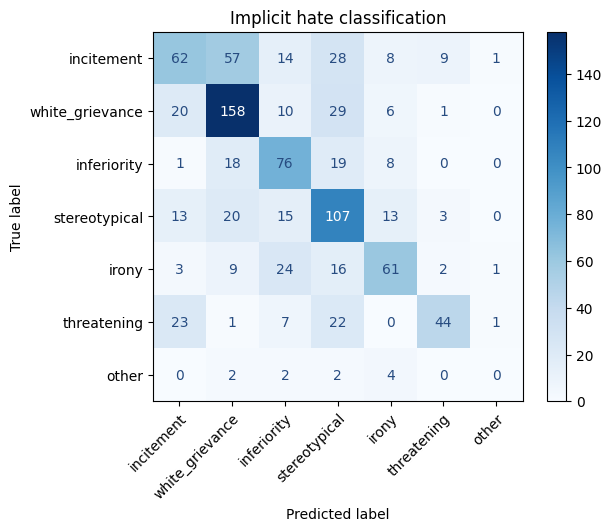

In [38]:
result_file_stg2 = result_folder + model_name + "_result_baseline_stg2.csv"
df_baseline_stg2 = evaluate_stage_2(
    "Baseline",
    test_file_stg2,
    result_file_stg2
)

### Prompt Tree of Thoughts

Prompt ToT: F1-macro: 0.4083 accuracy: 0.4919 precision: 0.4175 recall: 0.4186 

                 precision    recall  f1-score   support

     incitement     0.4815    0.2155    0.2977       181
white_grievance     0.5567    0.7389    0.6350       226
    inferiority     0.4748    0.5410    0.5057       122
  stereotypical     0.4302    0.4503    0.4400       171
          irony     0.4462    0.5000    0.4715       116
    threatening     0.5333    0.4848    0.5079        99
          other     0.0000    0.0000    0.0000        10

       accuracy                         0.4919       925
      macro avg     0.4175    0.4186    0.4083       925
   weighted avg     0.4854    0.4919    0.4749       925

    
0.2977	0.635	0.5057	0.44	0.4715	0.5079	0.0





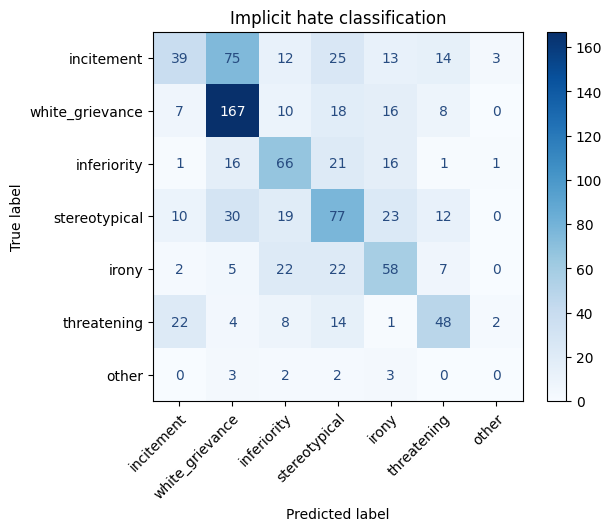

In [39]:
result_file_stg2 = result_folder + model_name + "_result_prompt_tot_stg2.csv"
df_prompt_tot_stg2 = evaluate_stage_2(
    "Prompt ToT",
    test_file_stg2,
    result_file_stg2
)

### Graph Tree of Thoughts

Graph ToT: F1-macro: 0.3674 accuracy: 0.4477 precision: 0.4244 recall: 0.3822 

                 precision    recall  f1-score   support

     incitement     0.3707    0.2638    0.3082       163
white_grievance     0.7843    0.3774    0.5096       212
    inferiority     0.3651    0.6389    0.4646       108
  stereotypical     0.4140    0.8075    0.5474       161
          irony     0.3784    0.2772    0.3200       101
    threatening     0.6585    0.3103    0.4219        87
          other     0.0000    0.0000    0.0000        10

       accuracy                         0.4477       842
      macro avg     0.4244    0.3822    0.3674       842
   weighted avg     0.5087    0.4477    0.4342       842

    
0.3082	0.5096	0.4646	0.5474	0.32	0.4219	0.0





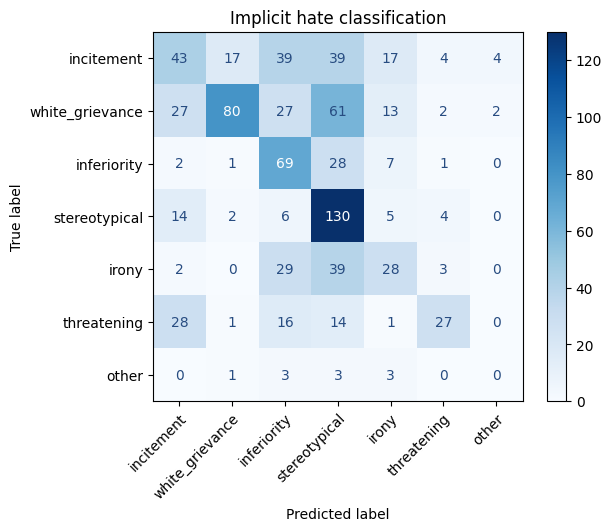

In [40]:
result_file_stg2 = result_folder + model_name + "_result_graph_stg2.csv"
df_graph_stg2 = evaluate_stage_2(
    "Graph ToT",
    test_file_stg2,
    result_file_stg2
)

### Optimizer MIPRO

Optimizer: F1-macro: 0.5164 accuracy: 0.5805 precision: 0.5579 recall: 0.5099 

                 precision    recall  f1-score   support

     incitement     0.7692    0.3867    0.5147       181
white_grievance     0.6189    0.7832    0.6914       226
    inferiority     0.6061    0.4918    0.5430       122
  stereotypical     0.5917    0.5848    0.5882       171
          irony     0.6000    0.4655    0.5243       116
    threatening     0.7075    0.7576    0.7317        99
          other     0.0119    0.1000    0.0213        10

       accuracy                         0.5805       925
      macro avg     0.5579    0.5099    0.5164       925
   weighted avg     0.6421    0.5805    0.5943       925

    
0.5147	0.6914	0.543	0.5882	0.5243	0.7317	0.0213





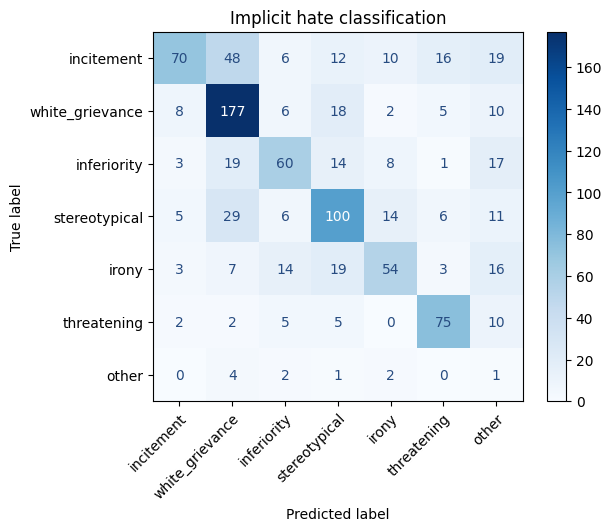

In [41]:
result_file_stg2 = result_folder + model_name + "_result_optimizer_stg2.csv"
df_optim_stg2 = evaluate_stage_2(
    "Optimizer",
    test_file_stg2,
    result_file_stg2
)

## Final results Stage 2

In [42]:
df_result_stg2 = pd.concat([df_baseline_stg2, df_prompt_tot_stg2, df_graph_stg2, df_optim_stg2])

In [ ]:
df_result_stg2.to_excel(result_folder +  model_name + '_evaluation_stg2.xlsx', index = False)

In [43]:
df_result_stg2 = pd.read_excel(result_folder + model_name + '_evaluation_stg2.xlsx')

In [190]:
df_result_stg2.round(4).head()

,Strategy,F1-macro,Precision,Recall,Accuracy
0,Baseline,0.4699,0.4934,0.4679,0.5522
1,Prompt ToT,0.4083,0.4175,0.4186,0.4919
2,Graph ToT,0.3674,0.4244,0.3822,0.4477
3,Optimizer,0.5164,0.5579,0.5099,0.5805


### Qualitative analysis (results of MIPRO optimizer)

In [45]:
df_gold_stg2 = pd.read_csv(data_folder + "implicit_hate_test_stg2.csv", encoding = 'utf-8')
df_pred_stg2 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg2.csv", encoding = 'utf-8')

#### Overall confidence

In [46]:
print(df_pred_stg2['confidence'].mean())

0.8525729729729729


In [47]:
df_pred_stg2.rename(columns={'implicit_class': 'implicit_class_pred'}, inplace=True)

In [48]:
df_pred_stg2.head()

,post_id,implicit_class_pred,confidence,explanation
0,9275,stereotypical,0.90,The post perpetuates negative stereotypes abou...
1,1006,white_grievance,0.85,"The post discusses a ""white privilege tax"" sup..."
2,20335,inferiority,0.75,"The post uses the derogatory term ""hermangutie..."
3,1173,white_grievance,0.90,The post expresses frustration and resentment ...
4,4917,stereotypical,0.90,The post perpetuates negative stereotypes abou...


In [49]:
df_merge_stg2 = pd.merge(df_gold_stg2, df_pred_stg2, on = 'post_id')

In [50]:
df_merge_stg2.head()

,post_id,post,implicit_class,implicit_class_pred,confidence,explanation
0,9275,""" : racist black thugs shoot white baby in t...",stereotypical,stereotypical,0.90,The post perpetuates negative stereotypes abou...
1,1006,"new "" white privilege tax "" "" for all white ...",white_grievance,white_grievance,0.85,"The post discusses a ""white privilege tax"" sup..."
2,20335,"if you even pay taxes, hermangutierr.",stereotypical,inferiority,0.75,"The post uses the derogatory term ""hermangutie..."
3,1173,agree . i'm sick of these self-hating behavior...,white_grievance,white_grievance,0.90,The post expresses frustration and resentment ...
4,4917,blacks have the best party time in white count...,stereotypical,stereotypical,0.90,The post perpetuates negative stereotypes abou...


#### Confidence of correct predictions

In [51]:
print(df_merge_stg2[df_merge_stg2['implicit_class'] == df_merge_stg2['implicit_class']]['confidence'].mean())

0.8525729729729729


#### Confidence of wrong predictions

In [52]:
print(df_merge_stg2[df_merge_stg2['implicit_class'] != df_merge_stg2['implicit_class_pred']]['confidence'].mean())

0.833840206185567


#### Examples of misclassified posts

In [53]:
df_errors = df_merge_stg2[df_merge_stg2['implicit_class'] != df_merge_stg2['implicit_class_pred']]

In [54]:
for idx, row in df_errors.sample(10).iterrows():
    print('\nPost: ' + row['post'])
    print('Confidence: ' + str(row['confidence']) + ' - Gold class: ' + row['implicit_class'] +' - Pred class: ' + row['implicit_class_pred'])
    print('Explanation: ' + row['explanation'])


Post: tony abbott : europe is being invaded by non-whites | read more : via
Confidence: 0.9 - Gold class: inferiority - Pred class: incitement
Explanation: This post quotes a public figure stating that Europe is being "invaded by non-whites," which uses alarmist language to suggest a threat from non-white individuals. This aligns with the "incitement" category, as it attempts to elevate a sense of ingroup unity and power by portraying an outgroup as a threat. The high confidence level reflects the clear and direct nature of the inciting language used in the post.

Post: kill your just set white people back a 100 yrs and made race baiters look great !
Confidence: 0.8 - Gold class: threatening - Pred class: white_grievance
Explanation: This post expresses frustration and a sense of grievance towards a perceived setback for white people. The phrase "set white people back a 100 yrs" suggests a belief that white people are being unfairly targeted or disadvantaged, which aligns with the "wh

# Evaluation Stage 3

[BLEURT installation](https://github.com/google-research/bleurt)


In [ ]:
# Initialize BLEURT Scorer
checkpoint =  "../bleurt/bleurt/BLEURT-20"
bleurt_scorer = bleurt_score.BleurtScorer(checkpoint)

In [ ]:
result_file_stg3 = data_folder + 'implicit_hate_test_stg3.csv'

### Text similarity metrics

In [ ]:
def compute_similarity_metrics(generated, reference, bleurt_scorer, bert_lang='en'):

    generated_tokens = nltk.word_tokenize(generated.lower())
    reference_tokens = nltk.word_tokenize(reference.lower())

    # Compute BLEU Score

    # Smoothing method1: adds 1 to the numerator and denominator for higher-order n-grams with no matches, akin to additive smoothing.
    # Works well for very short sentences or cases with few matches.
    smoothing = SmoothingFunction().method1

    bleu = sentence_bleu([reference_tokens], generated_tokens, smoothing_function = smoothing)
    bleu_1 = sentence_bleu([reference_tokens], generated_tokens, weights=(1, 0, 0, 0), smoothing_function = smoothing)
    bleu_2 = sentence_bleu([reference_tokens], generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing) # Cumulative

    # Compute ROUGE Score (F1)
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge_scorer_obj.score(reference, generated)
    rouge_f1 = {
        'ROUGE-1': rouge_scores['rouge1'].fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].fmeasure
    }
    # Compute METEOR Score
    meteor = meteor_score([reference_tokens], generated_tokens)

    # Compute NIST Score
    n = np.min((len(reference_tokens),len(generated_tokens),2))
    nist = sentence_nist([reference_tokens], generated_tokens, n = n)

    # Compute BERTScore (F1)
    P, R, F1 = bert_score.score([generated], [reference], lang=bert_lang, verbose=False)
    bert_f1 = F1.mean().item()

    # Compute BLUERT score
    bleurt_scores = bleurt_scorer.score(references = [reference], candidates = [generated])
    if isinstance(bleurt_scores, list) and len(bleurt_scores) == 1:
        bleurt = bleurt_scores[0]
    else:
        0

    # Combine scores
    return {
        'BLEU-1' : bleu_1,
        'BLEU-2' : bleu_2,
        'BLEU': bleu,
        **rouge_f1,
        'METEOR' : meteor,
        'NIST' : nist,
        'BERTScore': bert_f1,
        'BLEURTScore' : bleurt
    }
    

## Target similarity

In [ ]:
def compute_target_similarity(strategy, gold_file, pred_file, bleurt_scorer, debug_mode = False):

    df_gold = pd.read_csv(gold_file, encoding="utf-8")
    df_pred = pd.read_csv(pred_file, encoding="utf-8")    
    
    df_pred = df_pred[df_pred['target'].notnull()]
    df_pred = df_pred[df_pred['target'].notna()] 
    
    if debug_mode:
        df_pred = df_pred.sample(2)
    
    df_gold.rename(columns={'target': 'target_gold'}, inplace=True)
    df_pred.rename(columns={'target': 'target_pred'}, inplace=True)
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    df_merge = pd.merge(df_gold, df_pred, on = "post_id")
    df_target = df_merge[['post_id', 'post', 'target_gold', 'target_pred']]
    
    # Compute metrics
    similarity_metrics = df_target.apply(lambda row: compute_similarity_metrics(row['target_pred'], row['target_gold'], bleurt_scorer), axis=1)
    
    # Flatten the metrics into separate columns
    metrics_df = pd.DataFrame(similarity_metrics.tolist())
    
    # Combine the original DataFrame with the metrics
    df_target_result = pd.concat([df_target, metrics_df], axis=1)
    df_target_result_max = df_target_result.groupby('post_id')[df_target_result.columns[4: ].tolist()].max()
    
    # Average results
    df_result = df_target_result_max[1: ].mean().to_frame().T
    df_result.insert(loc = 0, column = 'Strategy', value = strategy)
    
    return df_result

### Baseline

In [ ]:
target_similiarty_baseline = compute_target_similarity(
    'Baseline',
    result_file_stg3,
    result_folder + model_name + '_result_baseline_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Prompt Tree of Thoughts

In [ ]:
target_similiarty_prompt_tot = compute_target_similarity(
    'Prompt ToT',
    result_file_stg3,
    result_folder + model_name + '_result_prompt_tot_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Graph Tree of Thoughts

In [ ]:
target_similiarty_graph = compute_target_similarity(
    'Graph ToT',
    result_file_stg3,
    result_folder + model_name + '_result_graph_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Otimizer MIPRO

In [ ]:
target_similiarty_optimized = compute_target_similarity(
    'Optimized',
    result_file_stg3,
    result_folder + model_name + '_result_optimizer_stg3.csv',
    bleurt_scorer,
    debug_mode
)

## Result Target similarity

In [ ]:
target_similarity_result = pd.concat(
    [target_similiarty_baseline, 
     target_similiarty_prompt_tot, 
     target_similiarty_graph, 
     target_similiarty_optimized]
)

In [ ]:
if debug_mode == False:
    target_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_target.xlsx', index = False)

In [55]:
target_similarity_result = pd.read_excel(result_folder + model_name + '_evaluation_stg3_target.xlsx')

In [198]:
target_similarity_result.rename(columns={'BERTScore': 'BERT', 'BLEURTScore': 'BLEURT'}).round(4).head()

,Strategy,BLEU-1,BLEU-2,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,METEOR,NIST,BERT,BLEURT
0,Baseline,0.5578,0.2640,0.1263,0.6482,0.1687,0.6477,0.3651,0.2067,0.9470,0.5997
1,Prompt ToT,0.5139,0.2543,0.1204,0.5980,0.1616,0.5974,0.3537,0.2016,0.9385,0.5532
2,Graph ToT,0.4931,0.2344,0.1138,0.5930,0.1427,0.5924,0.3423,0.1803,0.9349,0.5531
3,Optimized,0.5996,0.3279,0.1425,0.6822,0.2529,0.6819,0.4165,0.2639,0.9535,0.5931


## Meaning similarity

In [ ]:
def compute_meaning_similarity(strategy, gold_file, pred_file, bleurt_scorer, debug_mode = False):

    df_gold = pd.read_csv(gold_file, encoding="utf-8")
    df_pred = pd.read_csv(pred_file, encoding="utf-8")

    df_pred = df_pred[df_pred['implied_statement'].notnull()]
    df_pred = df_pred[df_pred['implied_statement'].notna()]    
    
    if debug_mode:
        df_pred = df_pred.sample(2)
        
    df_gold.rename(columns={'implied_statement': 'implied_statement_gold'}, inplace=True)
    df_pred.rename(columns={'implied_statement': 'implied_statement_pred'}, inplace=True)
    
    df_gold = df_gold[df_gold['post_id'].isin(df_pred['post_id'])]
    df_pred = df_pred[df_pred['post_id'].isin(df_gold['post_id'])]
    
    df_gold.sort_values("post_id", axis=0, ascending=True, inplace=True)
    df_pred.sort_values("post_id", axis=0, ascending=True, inplace=True)
    
    df_merge = pd.merge(df_gold, df_pred, on = "post_id")
    df_meaning = df_merge[['post_id', 'post', 'implied_statement_gold', 'implied_statement_pred']]
    
    # Compute metrics
    similarity_metrics = df_meaning.apply(lambda row: compute_similarity_metrics(row['implied_statement_pred'], row['implied_statement_gold'], bleurt_scorer), axis=1)
    
    # Flatten the metrics into separate columns
    metrics_df = pd.DataFrame(similarity_metrics.tolist())
    
    # Combine the original DataFrame with the metrics
    df_meaning_result = pd.concat([df_meaning, metrics_df], axis=1)
    df_meaning_result_max = df_meaning_result.groupby('post_id')[df_meaning_result.columns[4: ].tolist()].max()
    
    # Average results
    df_result = df_meaning_result_max[1: ].mean().to_frame().T
    df_result.insert(loc = 0, column = 'Strategy', value = strategy)

    return df_result
    

### Baseline

In [ ]:
meaning_similiarty_baseline = compute_meaning_similarity(
    'Baseline',
    result_file_stg3,
    result_folder + model_name + '_result_baseline_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Prompt Tree of Thoughts

In [ ]:
meaning_similiarty_prompt_tot = compute_meaning_similarity(
    'Prompt ToT',
    result_file_stg3,
    result_folder +  model_name + '_result_prompt_tot_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Graph Tree of Thoughts

In [ ]:
meaning_similiarty_graph = compute_meaning_similarity(
    'Graph ToT',
    result_file_stg3,
    result_folder + model_name + '_result_graph_stg3.csv',
    bleurt_scorer,
    debug_mode
)

### Optimizer MIPRO

In [ ]:
meaning_similiarty_optimized = compute_meaning_similarity(
    'Optimized',
    result_file_stg3,
    result_folder + model_name + '_result_optimizer_stg3.csv',
    bleurt_scorer,
    debug_mode
)

## Results Meaning similarity

In [ ]:
meaning_similarity_result = pd.concat(
    [meaning_similiarty_baseline,
     meaning_similiarty_prompt_tot, 
     meaning_similiarty_graph, 
     meaning_similiarty_optimized]
)

In [ ]:
if debug_mode == False:
    meaning_similarity_result.to_excel(result_folder + model_name + '_evaluation_stg3_meaning.xlsx', index = False)

In [57]:
meaning_similarity_result = pd.read_excel(result_folder + model_name + '_evaluation_stg3_meaning.xlsx')

In [199]:
meaning_similarity_result.rename(columns={'BERTScore': 'BERT', 'BLEURTScore': 'BLEURT'}).round(4).head()

,Strategy,BLEU-1,BLEU-2,BLEU,ROUGE-1,ROUGE-2,ROUGE-L,METEOR,NIST,BERT,BLEURT
0,Baseline,0.3123,0.2013,0.1105,0.4253,0.1903,0.4132,0.3083,0.6514,0.9135,0.4863
1,Prompt ToT,0.2762,0.1699,0.0842,0.3762,0.1583,0.3645,0.3037,0.6085,0.9049,0.4676
2,Graph ToT,0.2715,0.1673,0.0829,0.3765,0.1547,0.3632,0.2965,0.5925,0.9055,0.4734
3,Optimized,0.4101,0.2864,0.1637,0.5017,0.3028,0.4893,0.4200,0.8954,0.9247,0.5212


### Qualitative analysis (target, MIPRO results)

In [207]:
df_gold_stg3 = pd.read_csv(data_folder + "implicit_hate_test_stg3.csv", encoding = 'utf-8')
df_pred_stg3 = pd.read_csv(result_folder + model_name + "_result_optimizer_stg3.csv", encoding = 'utf-8')

In [208]:
df_gold_stg3['target'] = df_gold_stg3['target'].str.lower()
df_pred_stg3['target'] = df_pred_stg3['target'].str.lower()

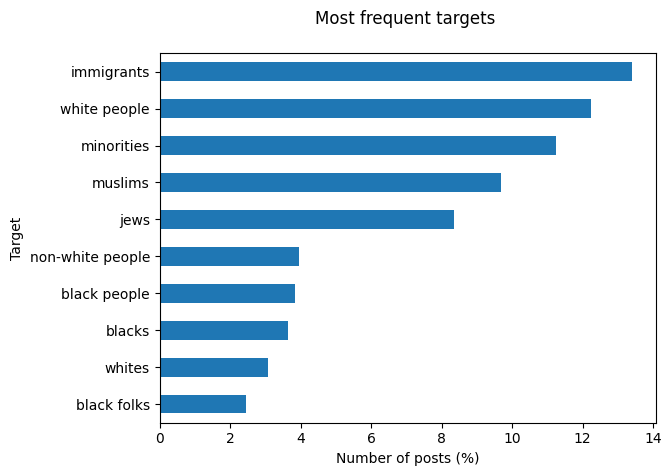

In [209]:
p = df_gold_stg3.groupby(['target'])['post_id'].count().div(len(df_gold_stg3)).multiply(100).sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts (%)', 
    ylabel = 'Target',  
    title = 'Most frequent targets \n'
)                                                                               

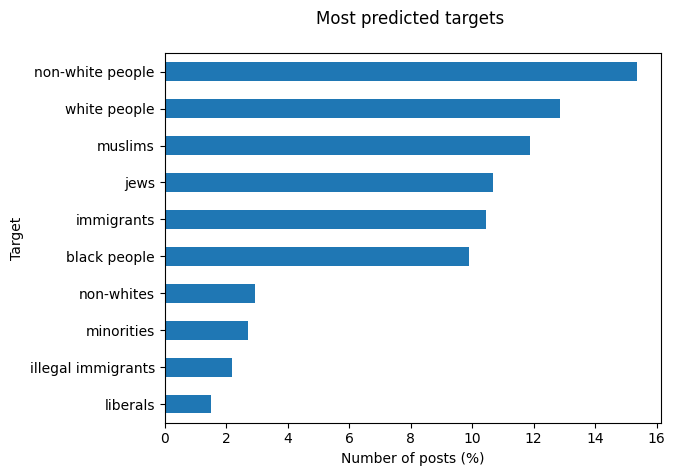

In [210]:
p = df_pred_stg3.groupby(['target'])['post_id'].count().div(len(df_pred_stg3)).multiply(100).sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts (%)', 
    ylabel = 'Target',  
    title = 'Most predicted targets \n'
)

#### Immigrants

In [63]:
df_immigrants = df_gold_stg3[df_gold_stg3['target'] == 'immigrants']

In [64]:
df_pred_immigrants = df_pred_stg3[df_pred_stg3['post_id'].isin(df_immigrants['post_id'])]
df_pred_immigrants = df_pred_immigrants[df_pred_immigrants['target'] != 'immigrants']

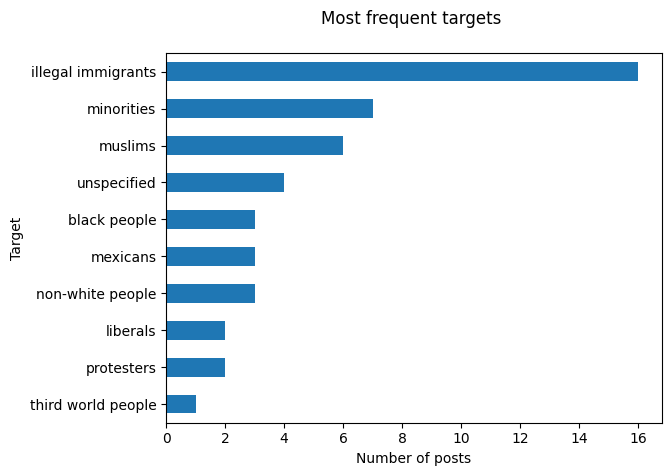

In [65]:
p = df_pred_immigrants.groupby(['target'])['post_id'].count().sort_values().tail(10).plot(
    kind = 'barh', 
    xlabel='Number of posts', 
    ylabel = 'Target',  
    title = 'Most frequent targets \n'
) 

In [110]:
df_pred_immigrants[df_pred_immigrants['target'] != 'immigrants'].sample(10)

,post_id,target,implied_statement
554,20333,indigenous people,Indigenous people are harmful and deserve reta...
455,121,african refugees,African refugees are rapists.
129,19171,muslims,Muslims are uncivilized.
302,11267,illegal immigrants,Illegal Immigrants are a problem.
413,20724,black people,Black people are uncivilized.
27,5711,third world people,Third world people are unintelligent.
543,20261,mexicans,Mexicans are illegal immigrants.
726,6730,illegal immigrants,Illegal Immigrants are invading.
558,19189,minorities,Minorities are animals.
5,20730,unspecified,The unspecified group should be harmed.


#### Example of post correctly classified by Tree of Thought Graph

In [113]:
df_merge_stg3 = pd.merge(df_gold_stg3, df_pred_stg3.rename(columns={'target': 'target_pred', 'implied_statement': 'implied_statemen_pred'}), on = 'post_id')

In [115]:
df_merge_stg3.head()

,post_id,post,target,implied_statement,target_pred,implied_statemen_pred
0,1006,"new "" white privilege tax "" "" for all white ...",minorities,Minorities promote racism.,white people,White people are privileged.
1,1006,"new "" white privilege tax "" "" for all white ...",minorities,Minorities are oppressors,white people,White people are privileged.
2,1173,agree . i'm sick of these self-hating behavior...,white people,White people hate other white people.,white people,White people are self-destructive.
3,1173,agree . i'm sick of these self-hating behavior...,minorities,Minorities push shame on to whites.,white people,White people are self-destructive.
4,4917,blacks have the best party time in white count...,black people,Black people are on welfare.,black people,Black people are exploitative.


In [116]:
correct_stg1 = df_merge_stg1[df_merge_stg1['class'] == df_merge_stg1['class_pred']]['post_id'].to_list()

In [117]:
correct_stg2 = df_merge_stg2[df_merge_stg2['implicit_class'] == df_merge_stg2['implicit_class_pred']]['post_id'].to_list()

In [118]:
correct_stg3 =df_merge_stg3[df_merge_stg3['target'] == df_merge_stg3['target_pred']]['post_id'].to_list()

In [119]:
correct = list(set(correct_stg1) & set(correct_stg2) & set(correct_stg3))

In [120]:
len(correct)

240

In [121]:
correct[0]

19457

In [192]:
line_sep = '\n' + '-' * 100

In [193]:
filename = result_folder + '/responses/mistral_19457.json'
with open(filename, 'r') as f:
    text = f.read()
    obj = json.loads(text)
    hate = eval(obj['hate_class']['repr'])

print(line_sep)
print('Post\n\n' + obj['post'])
print(line_sep)
print('Abuse subtypes\n\n' + obj['abuse_subtypes']['kwargs']['content'])
print(line_sep)
print('World knowledge\n\n' + obj['world_knowledge']['kwargs']['content'])
print(line_sep)
print('Generate interpretations\n\n' + obj['interpretations']['kwargs']['content'])
print(line_sep)
print('Evaluate interpretations\n')
hate = eval(obj['hate_class']['repr'])
print('Class: ' + hate.hate_class) 
print('Confidence: ' + str(hate.confidence))
print('Explanation: ' + hate.explanation) 
print(line_sep)
print('Classify implicit hate\n')
implicit_hate_class = eval(obj['implicit_hate_class']['repr'])
print('Implicit hate class: ' + implicit_hate_class.implicit_class_1)
print('Explanation: '+ implicit_hate_class.explanation)
print(line_sep)
print('Identify implied meaning\n')
implied_meaning = eval(obj['implied_meaning']['repr'])
print('Targeted group: ' + implied_meaning.targeted_group)
print('Implied statement: ' +implied_meaning.implied_statement)


----------------------------------------------------------------------------------------------------
Post

the best medicine for perverts is to ship to isil..they will take good care of u..

----------------------------------------------------------------------------------------------------
Abuse subtypes

The text contains implicit abusive language that falls under the subtype:

6. Call for Action: Statements urging actions, often harmful, against a group (e.g., "He should be given 5000 volts!").

The text suggests sending individuals labeled as "perverts" to ISIL, implying that they will be harmed or mistreated, which is a call for harmful action against a group.

----------------------------------------------------------------------------------------------------
World knowledge

The text falls under the category of "Other Implicit Abuse." The statement suggests that individuals deemed "perverts" should be sent to ISIL (another name for ISIS), implying that they will be severely pun